In [1]:
from siphon.catalog import TDSCatalog
import xarray as xr
import cfgrib
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import numpy as np
import metpy.units as units
from metpy.plots import USCOUNTIES


C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
dt = datetime.utcnow()

In [3]:
rtma_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml')
print("Available datasets:")
for dataset_name in rtma_cat.datasets:
    print(dataset_name)

Available datasets:
Full Collection (Reference / Forecast Time) Dataset
Best Real Time Mesoscale Analysis 2.5 km Time Series
Latest Collection for Real Time Mesoscale Analysis 2.5 km


In [4]:

rtma_data = rtma_cat.datasets['Latest Collection for Real Time Mesoscale Analysis 2.5 km'].remote_access(use_xarray=True)
rtma_data = rtma_data.metpy.parse_cf()

In [5]:
rtma_data

<xarray.Dataset>
Dimensions:                                                              (
                                                                          time1: 1,
                                                                          : 2,
                                                                          x: 2145,
                                                                          y: 1377,
                                                                          time: 1,
                                                                          height_above_ground1: 1,
                                                                          altitude_above_msl: 1,
                                                                          height_above_ground: 1)
Coordinates:
    reftime                                                              datetime64[ns] ...
  * time1                                                                (time1) datetime64[ns] ...
  * x                                                                    (x) float32 ...
  * y                                                                    (y) float32 ...
  * time                                                                 (time) datetime64[ns] ...
  * height_above_ground1                                                 (height_above_ground1) float32 ...
    metpy_crs                                                            object ...
  * altitude_above_msl                                                   (altitude_above_msl) float32 ...
  * height_above_ground                                                  (height_above_ground) float32 ...
Dimensions without coordinates: 
Data variables: (12/22)
    LambertConformal_Projection                                          int32 ...
    time1_bounds                                                         (time1, ) datetime64[ns] ...
    Dewpoint_temperature_Analysis_height_above_ground                    (time, height_above_ground1, y, x) float32 ...
    Dewpoint_temperature_error_height_above_ground                       (time, height_above_ground1, y, x) float32 ...
    Geopotential_height_Analysis_surface                                 (time, y, x) float32 ...
    Pressure_error_surface                                               (time, y, x) float32 ...
    ...                                                                   ...
    Wind_speed_error_height_above_ground                                 (time, height_above_ground, y, x) float32 ...
    Wind_speed_Analysis_height_above_ground                              (time, height_above_ground, y, x) float32 ...
    Wind_speed_gust_Analysis_height_above_ground                         (time, height_above_ground, y, x) float32 ...
    Wind_speed_gust_error_height_above_ground                            (time, height_above_ground, y, x) float32 ...
    u-component_of_wind_Analysis_height_above_ground                     (time, height_above_ground, y, x) float32 ...
    v-component_of_wind_Analysis_height_above_ground                     (time, height_above_ground, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

In [6]:
pressure = rtma_data['Pressure_Analysis_surface'].sel(time=dt, method='nearest').squeeze()

In [7]:
pressure

<xarray.DataArray 'Pressure_Analysis_surface' (y: 1377, x: 2145)>
[2953665 values with dtype=float32]
Coordinates:
    reftime    datetime64[ns] 2024-06-07T16:00:00
  * x          (x) float32 -2.763e+06 -2.761e+06 ... 2.679e+06 2.682e+06
  * y          (y) float32 -2.638e+05 -2.612e+05 ... 3.228e+06 3.231e+06
    time       datetime64[ns] 2024-06-07T16:00:00
    metpy_crs  object Projection: lambert_conformal_conic
Attributes: (12/13)
    long_name:                       Pressure Analysis @ Ground or water surface
    units:                           Pa
    abbreviation:                    PRES
    grid_mapping:                    LambertConformal_Projection
    Grib_Variable_Id:                VAR_0-3-0_L1
    Grib2_Parameter:                 [0 3 0]
    ...                              ...
    Grib2_Parameter_Category:        Mass
    Grib2_Parameter_Name:            Pressure
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Analysis
    Grib2_Statistical_Process_Type:  UnknownStatType--1

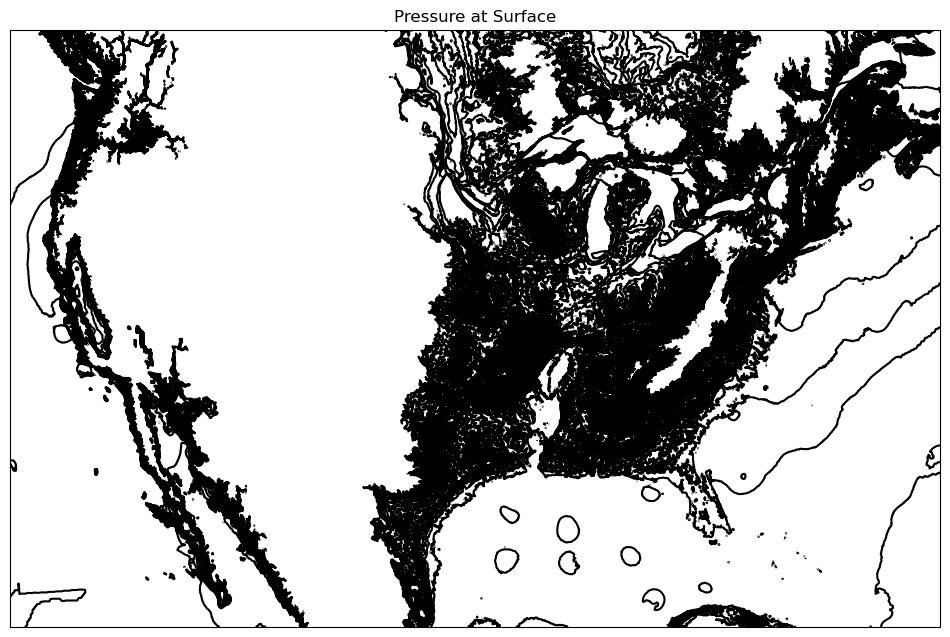

In [8]:
# Extract latitude and longitude coordinates
lats = pressure.metpy.coordinates('y')
lons = pressure.metpy.coordinates('x')

# Create a map projection
projection = ccrs.PlateCarree()
projection = pressure.metpy.cartopy_crs

# Create a plot with the map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

# Plot the pressure data
contour = ax.contour(pressure.metpy.x, pressure.metpy.y, pressure / 100, levels=np.arange(960, 1040, 4), transform=pressure.metpy.cartopy_crs, colors='black')
# Add colorbar and labels
#fig.colorbar(contour, ax=ax, label='Pressure (hPa)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Pressure at Surface')

# Show the plot
plt.show()

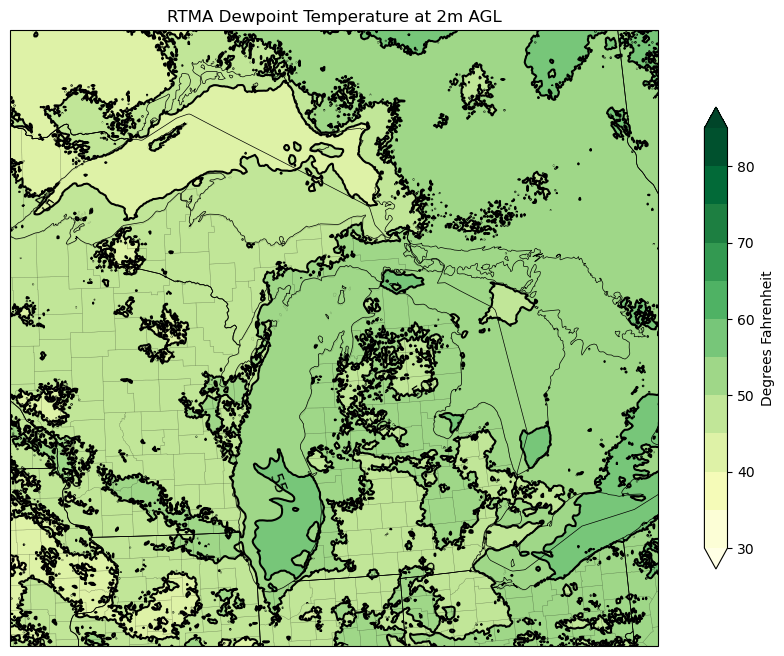

In [9]:
#td = rtma_data['Dewpoint_temperature_Analysis_height_above_ground'].sel(reftime1=dt, method='nearest').squeeze()
td = rtma_data['Dewpoint_temperature_Analysis_height_above_ground'].sel(time=dt, method='nearest').squeeze()
tdF = td.metpy.convert_units('degF')
projection = tdF.metpy.cartopy_crs

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

contourf = ax.contourf(tdF.metpy.x, tdF.metpy.y, tdF, transform=pressure.metpy.cartopy_crs, cmap='YlGn', levels=np.arange(30, 86, 5), extend='both')
fig.colorbar(contourf, ax=ax, shrink=0.75, label='Degrees Fahrenheit')
contour = ax.contour(tdF.metpy.x, tdF.metpy.y, tdF, transform=tdF.metpy.cartopy_crs, colors='Black', levels=np.arange(30, 86, 5), extend='both')
plt.clabel(contour, inline=1, fontsize=12, fmt="%i")

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('RTMA Dewpoint Temperature at 2m AGL')

ax.set_extent([-92, -80, 41, 49])
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha=0.25)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

plt.show()

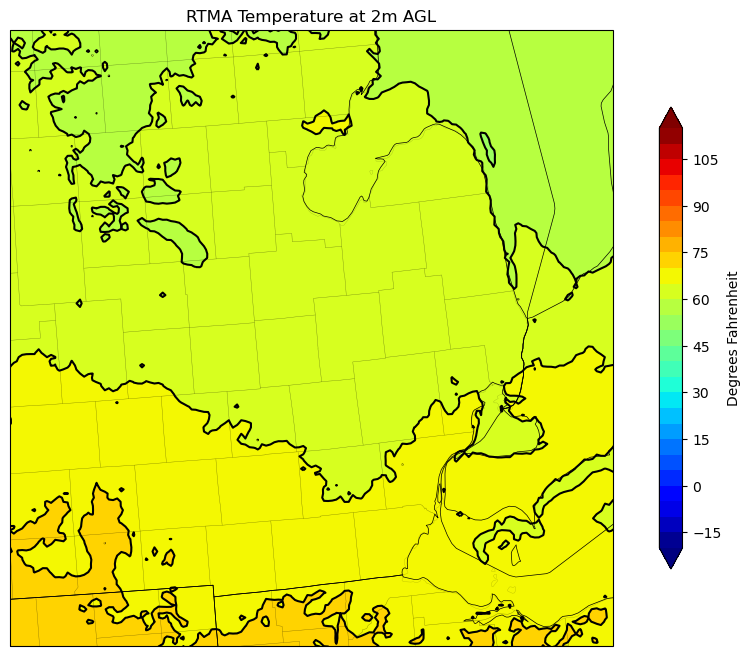

In [10]:
#t = rtma_data['Temperature_Analysis_height_above_ground'].sel(reftime1=dt, method='nearest').squeeze()
t = rtma_data['Temperature_Analysis_height_above_ground'].sel(time=dt, method='nearest').squeeze()
tF = t.metpy.convert_units('degF')
projection = tF.metpy.cartopy_crs

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

contourf = ax.contourf(tF.metpy.x, tF.metpy.y, tF, transform=projection, cmap='jet', levels=np.arange(-20, 120, 5), extend='both')
fig.colorbar(contourf, ax=ax, shrink=0.75, label='Degrees Fahrenheit')
contour = ax.contour(tF.metpy.x, tF.metpy.y, tF, transform=projection, colors='Black', levels=np.arange(-20, 120, 5), extend='both')
plt.clabel(contour, inline=1, fontsize=12, fmt="%i")

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('RTMA Temperature at 2m AGL')

ax.set_extent([-86, -82, 41.5, 44.5])
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha=0.25)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

plt.show()

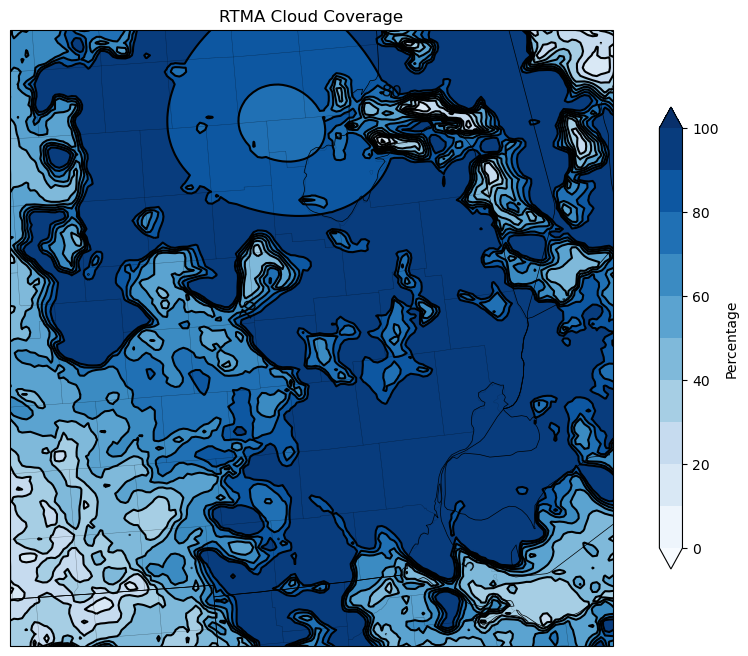

In [11]:
clouds = rtma_data['Total_cloud_cover_Analysis_entire_atmosphere_single_layer'].sel(time=dt, method='nearest').squeeze()
projection = clouds.metpy.cartopy_crs

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

contourf = ax.contourf(clouds.metpy.x, clouds.metpy.y, clouds, transform=projection, cmap='Blues', levels=np.arange(0, 101, 10), extend='both')
fig.colorbar(contourf, ax=ax, shrink=0.75, label='Percentage')
contour = ax.contour(clouds.metpy.x, clouds.metpy.y, clouds, transform=projection, colors='Black', levels=np.arange(0, 101, 10))
plt.clabel(contour, inline=1, fontsize=12, fmt="%i")

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('RTMA Cloud Coverage')

ax.set_extent([-86, -82, 41.5, 44.5])
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha=0.25)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

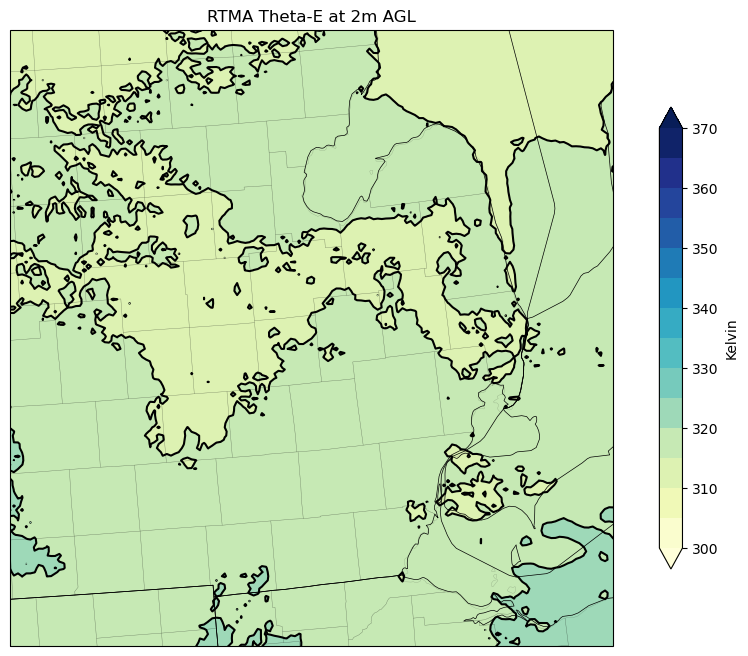

In [12]:
theta_e = mpcalc.equivalent_potential_temperature(pressure, t, td)

projection = theta_e.metpy.cartopy_crs

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

contourf = ax.contourf(theta_e.metpy.x, theta_e.metpy.y, theta_e, transform=projection, cmap='YlGnBu', levels=np.arange(300, 371, 5), extend='both')
fig.colorbar(contourf, ax=ax, shrink=0.75, label='Kelvin')
contour = ax.contour(theta_e.metpy.x, theta_e.metpy.y, theta_e, transform=projection, colors='Black', levels=np.arange(300, 371, 5), extend='both')
plt.clabel(contour, inline=1, fontsize=12, fmt="%i")

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('RTMA Theta-E at 2m AGL')

ax.set_extent([-86, -82, 41.5, 44.5])
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha=0.25)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

plt.show()

In [13]:
u = rtma_data['u-component_of_wind_Analysis_height_above_ground'].sel(time=dt, method='nearest').squeeze()
v = rtma_data['v-component_of_wind_Analysis_height_above_ground'].sel(time=dt, method='nearest').squeeze()

In [14]:
div = mpcalc.divergence(u, v)

C:\Users\Tony\AppData\Local\Temp\ipykernel_26896\952288214.py:1: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  div = mpcalc.divergence(u, v)


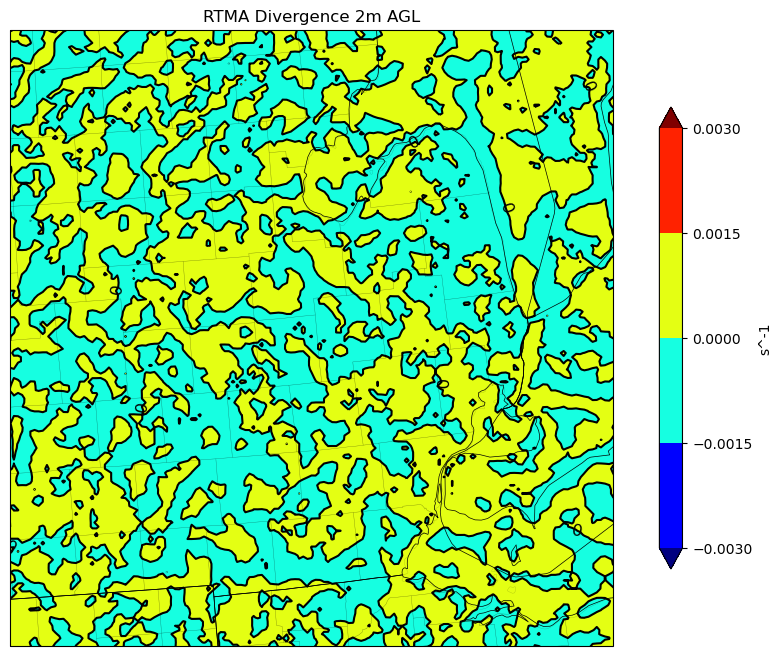

In [19]:
projection = div.metpy.cartopy_crs

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

contourf = ax.contourf(div.metpy.x, div.metpy.y, div, transform=projection, cmap='jet', extend='both')
fig.colorbar(contourf, ax=ax, shrink=0.75, label='s^-1')
contour = ax.contour(div.metpy.x, div.metpy.y, div, transform=projection, colors='Black', extend='both')
plt.clabel(contour, inline=1, fontsize=12, fmt="%i")
#ax.barbs(div.metpy.x, div.metpy.y, u,v, color='black', length=5, alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('RTMA Divergence 2m AGL')

ax.set_extent([-86, -82, 41.5, 44.5])
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha=0.25)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

plt.show()